# Task 2 : What’s inside the box?

In [98]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib

## **Import Image**

In [99]:
# Input image
import urllib
req = urllib.request.urlopen('https://github.com/AthimetA/FRA321/blob/main/IMGpro/img/L3_work_Task2.jpg?raw=true')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) 

In [100]:
def HistogramComparison(img):
    bgr_planes = cv2.split(img)
    histSize = 256
    histRange = (0, 256) # the upper boundary is exclusive
    accumulate = False
    b_hist = cv2.calcHist(bgr_planes, [0], None, [histSize], histRange, accumulate=accumulate)
    g_hist = cv2.calcHist(bgr_planes, [1], None, [histSize], histRange, accumulate=accumulate)
    r_hist = cv2.calcHist(bgr_planes, [2], None, [histSize], histRange, accumulate=accumulate)
    hist_w = 512
    hist_h = 400
    bin_w = int(round( hist_w/histSize ))
    histImage = np.zeros((hist_h, hist_w, 3), dtype=np.uint8)
    cv2.normalize(b_hist, b_hist, alpha=0, beta=hist_h, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(g_hist, g_hist, alpha=0, beta=hist_h, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(r_hist, r_hist, alpha=0, beta=hist_h, norm_type=cv2.NORM_MINMAX)
    for i in range(1, histSize):
        cv2.line(histImage, ( bin_w*(i-1), hist_h - int(b_hist[i-1]) ),
                ( bin_w*(i), hist_h - int(b_hist[i]) ),
                ( 255, 0, 0), thickness=2)
        cv2.line(histImage, ( bin_w*(i-1), hist_h - int(g_hist[i-1]) ),
                ( bin_w*(i), hist_h - int(g_hist[i]) ),
                ( 0, 255, 0), thickness=2)
        cv2.line(histImage, ( bin_w*(i-1), hist_h - int(r_hist[i-1]) ),
                ( bin_w*(i), hist_h - int(r_hist[i]) ),
                ( 0, 0, 255), thickness=2)
    return histImage

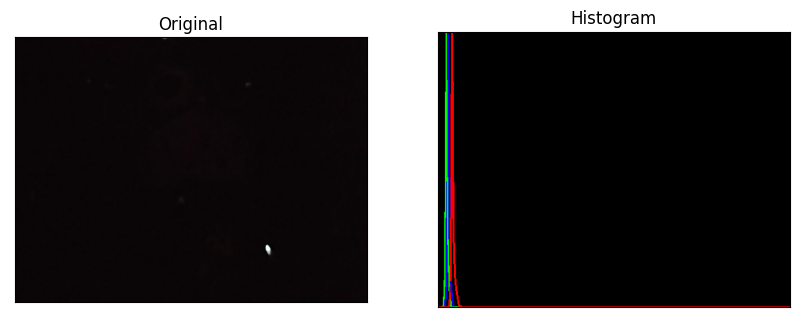

In [101]:
histImage = HistogramComparison(img)

plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(histImage, cv2.COLOR_BGR2RGB))
plt.title('Histogram'), plt.xticks([]), plt.yticks([])
plt.show()

จากการ Plot histogram ของรูปภาพที่ได้รับมาพบว่า histogram ของรูปภาพมีค่ากระจุกรวมกันอยู่ในจุดที่ใกล้ค่า 0 เนื่องจากภาพทั้งหมดเป็นสีดำ

## **Log Transformation**

C:\Users\AthimetA\AppData\Local\Temp\ipykernel_18500\2137505631.py:3: RuntimeWarning: divide by zero encountered in log
  log_image = c * (np.log(img + 1))


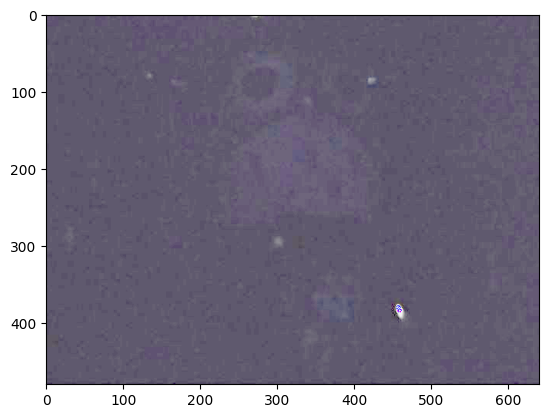

In [102]:
# Apply log transformation method
c = 255 / np.log(1 + np.max(img))
log_image = c * (np.log(img + 1))
   
# Specify the data type so that
# float value will be converted to int
log_image = np.array(log_image, dtype = np.uint8)
plt.imshow(log_image)

โดยผลลัพธ์ที่ได้จากการทำ Log Transformation จะเห็นได้ว่าทำให้รูปภาพมีความสว่างขึ้นแต่ก็ยังไม่สามารถเห็นรายละเอียดของรูปภาพได้ จึงจะเก็บผลลัพธ์ไว้พิจารณาในขั้นตอนต่อไป

## **Gramma Tranform**

In [103]:
def GammaTransform(img, gamma):
    # Apply gamma transform.
    gamma_transformed = np.array(255*(img/255)**gamma, dtype = 'uint8')
    return gamma_transformed

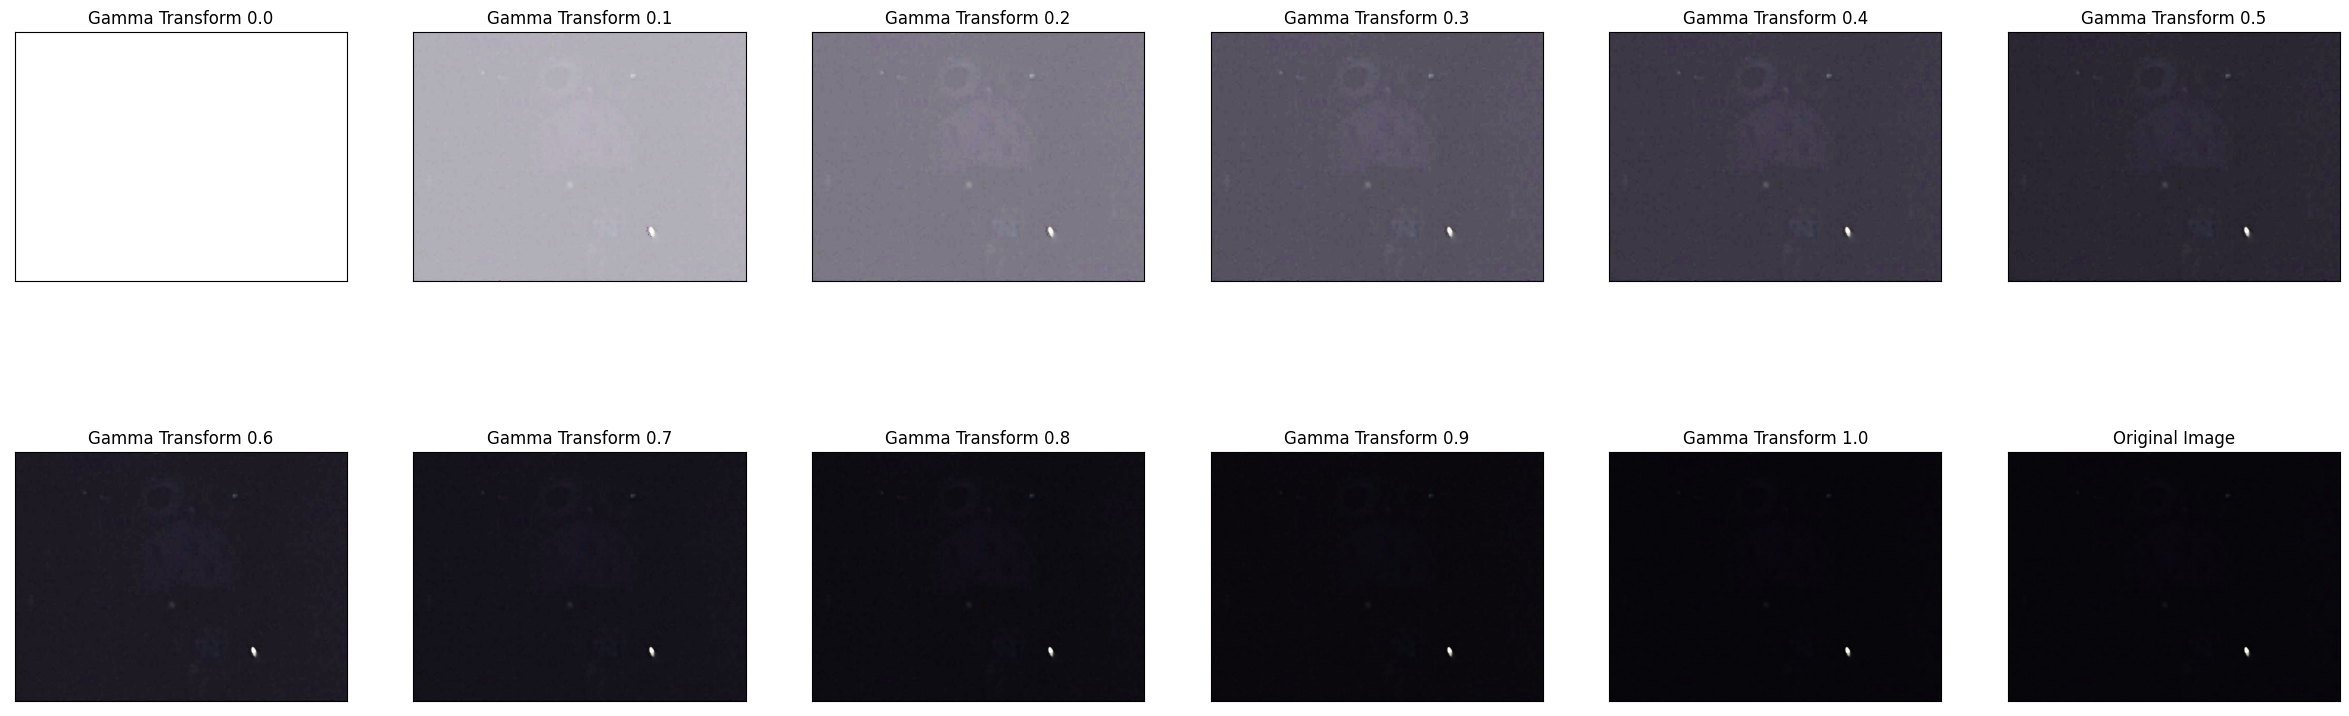

In [104]:
gamma = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
gammaplot = []
plt.figure(figsize=(30, 10))
for i in range(len(gamma)):
    gammaplot.append(GammaTransform(img, gamma[i]))
    plt.subplot(2,6,i+1), plt.imshow(gammaplot[i], cmap = 'gray')
    plt.title('Gamma Transform '+str(gamma[i])), plt.xticks([]), plt.yticks([])
plt.subplot(2,6,12), plt.imshow(img, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.show()

หลังจากทำลองการใช้ gramma transform แล้วพบว่าการใช้ gramma transform จะทำให้ภาพมีความสว่างขึ้นโดยค่าของ gramma ที่ทำให้เห็นภาพได้ดีที่สุดคือ 0.3 ดังนั้นแล้วจะพิจารณาใช้ gramma transform ที่ 0.3 ในการแก้ไขภาพต่อไป

In [105]:
imggamma = GammaTransform(img, 0.3)

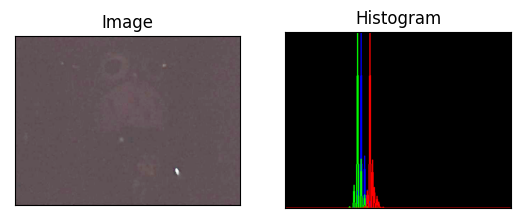

In [106]:
histImage = HistogramComparison(imggamma)

plt.subplot(121), plt.imshow(cv2.cvtColor(imggamma, cv2.COLOR_BGR2RGB))
plt.title('Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(histImage, cv2.COLOR_BGR2RGB))
plt.title('Histogram'), plt.xticks([]), plt.yticks([])
plt.show()

หลังจากนั้นจึงทำการใช้ gramma transform แล้ว histogram ของภาพจะมีค่ากระจุกรวมกันอยู่ในจุดที่ไกลกับค่า 0 มากขึ้นแต่ก็ยังไม่สามารถเห็นภาพได้ดีเพราะภาพยังเป็นสีดำและมีรายละเอียดที่น้อยอยู่

## **Arithmetic Transform**

In [107]:
def ArithmeticTransform(img1, img2=None , operation='not'):
    # img1 is the input image
    # img2 is the input image
    # operation is the operation to be performed
    if operation == 'and':
        imgOut = cv2.bitwise_and(img1, img2)
    elif operation == 'or':
        imgOut = cv2.bitwise_or(img1, img2)
    elif operation == 'xor':
        imgOut = cv2.bitwise_xor(img1, img2)
    elif operation == 'not':
        imgOut = cv2.bitwise_not(img1)
    imgOut = np.clip(imgOut, 0, 255)
    imgOut = imgOut.astype(np.uint8)
    return imgOut

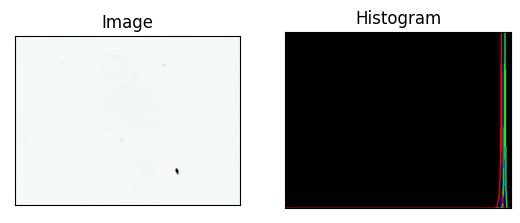

In [108]:
imgnot = ArithmeticTransform(img)

histImage = HistogramComparison(imgnot)

plt.subplot(121), plt.imshow(cv2.cvtColor(imgnot, cv2.COLOR_BGR2RGB))
plt.title('Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(histImage, cv2.COLOR_BGR2RGB))
plt.title('Histogram'), plt.xticks([]), plt.yticks([])
plt.show()

ทำการทดลองใช้ Arithmetic Transform โดยจะกลับ bit ของภาพโดยใช้ operation not เผื่อจะทำให้ได้ข้อมูลบางอย่างเพิ่มเติม

## **Histogram Equalization**

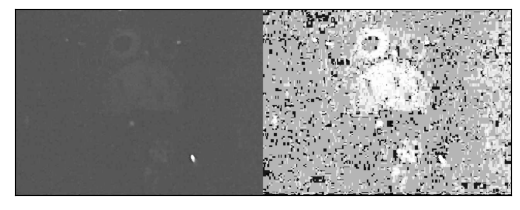

In [109]:
imgHisr = cv2.cvtColor(imggamma, cv2.COLOR_BGR2GRAY)

equr = cv2.equalizeHist(imgHisr)
  
# stacking images side-by-side
resr = np.hstack((imgHisr, equr))

# plotting the images
plt.imshow(cv2.cvtColor(resr, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

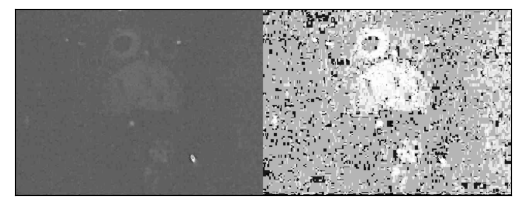

In [110]:
imgHis = cv2.cvtColor(log_image, cv2.COLOR_BGR2GRAY)

equ = cv2.equalizeHist(imgHis)
  
# stacking images side-by-side
res = np.hstack((imgHis, equ))

# plotting the images
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

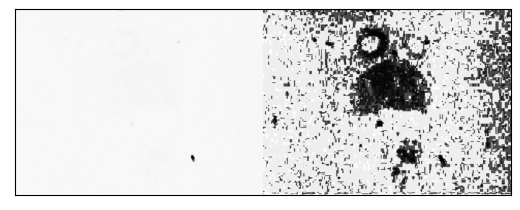

In [111]:
imgHisnot = cv2.cvtColor(imgnot, cv2.COLOR_BGR2GRAY)

equnot = cv2.equalizeHist(imgHisnot)
  
# stacking images side-by-side
resnot = np.hstack((imgHisnot, equnot))

# plotting the images
plt.imshow(cv2.cvtColor(resnot, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

หลังจากที่ทำการทำ histogram equalization แล้วพบว่าภาพที่ได้จะมีความสว่างขึ้นและมีรายละเอียดของภาพที่เห็นได้ดีขึ้นมาก ดังนั้นจึงเลือกใช้ histogram equalization ในการแก้ไขภาพต่อไป โดยจะเลือกใช้ histogram equalization ของ log tranform (ผลลัพธ์ที่ได้จากการทำ log transformation และ gramma transform ไม่แตกต่งากันมากจนเห็นได้ชัด)

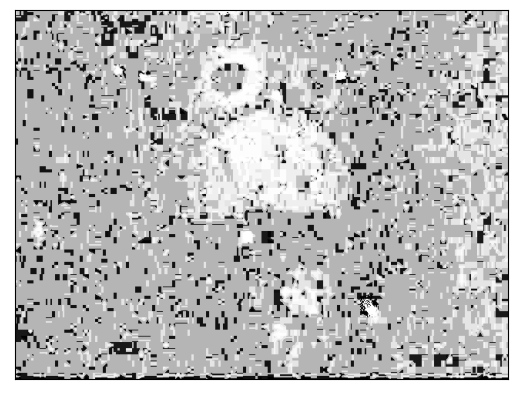

In [112]:
img = equ.copy()
plt.xticks([]), plt.yticks([])
plt.imshow(img, cmap = 'gray')

## **Bit Plane Slicing**

In [113]:
def BitPlaneSlicing(img, n):
    # Apply bit plane slicing.
    bit_plane_sliced = np.array(img, dtype = np.uint8)
    # Shift the bits of the image to the right by n-1.
    bit_plane_sliced = np.vectorize(lambda x: x if (x & (1 << n)) else 0)(bit_plane_sliced)
    return bit_plane_sliced

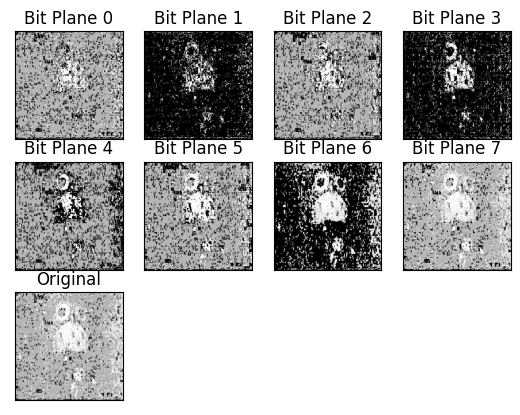

In [114]:
imgbit = cv2.resize(equ, (256, 256), interpolation=cv2.INTER_LINEAR)

for i in range(8):
    imgbitn = BitPlaneSlicing(imgbit, i)
    plt.subplot(3,4,i+1), plt.imshow(imgbitn, cmap = 'gray')
    plt.title('Bit Plane '+str(i)), plt.xticks([]), plt.yticks([])
plt.subplot(3,4,9), plt.imshow(imgbit, cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.show()

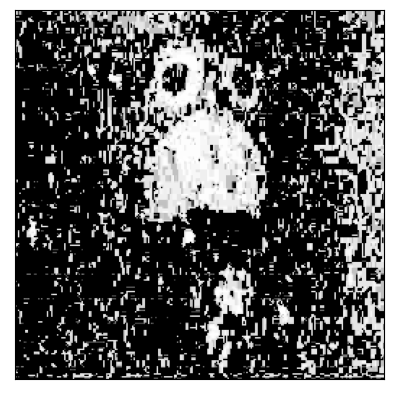

In [115]:
imgbit6 = BitPlaneSlicing(imgbit, 6)
plt.xticks([]), plt.yticks([])
plt.imshow(imgbit6, cmap = 'gray')

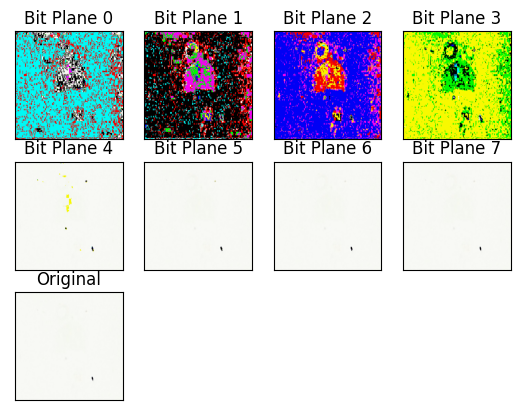

In [116]:
imgbit = cv2.resize(imgnot, (256, 256), interpolation=cv2.INTER_LINEAR)

for i in range(8):
    imgbitn = BitPlaneSlicing(imgbit, i)
    plt.subplot(3,4,i+1), plt.imshow(imgbitn, cmap = 'gray')
    plt.title('Bit Plane '+str(i)), plt.xticks([]), plt.yticks([])
plt.subplot(3,4,9), plt.imshow(imgbit, cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.show()

หลังจากที่ทำ Bit Plane Slicing แล้วพบว่าภาพที่ได้จะมีรายละเอียดของภาพที่เห็นชัดมากขึ้นใน Bitplane ที่ 6 ดังนั้นจึงเลือกใช้ Bit Plane Slicing ที่ 6 เป็นภาพที่บ่งบอกรายละเอียดของภาพ

## **Final Result**

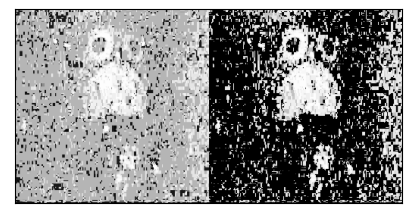

In [117]:
imgres = cv2.resize(equ, (256, 256), interpolation=cv2.INTER_LINEAR)
imgbitres = cv2.resize(imgbit6, (256, 256), interpolation=cv2.INTER_LINEAR)
resr = np.hstack((imgres, imgbitres))
plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(resr, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

โดยหลังจากที่ลองทำกระบวนการทั้งหมดสามารถสรุปได้ว่าภาพนี้เป็นภาพของตัวการ์ตูน"นกฮูก"ที่มีตาโต ๆ คล้าย ๆ ดังภาพต่อไปนี้

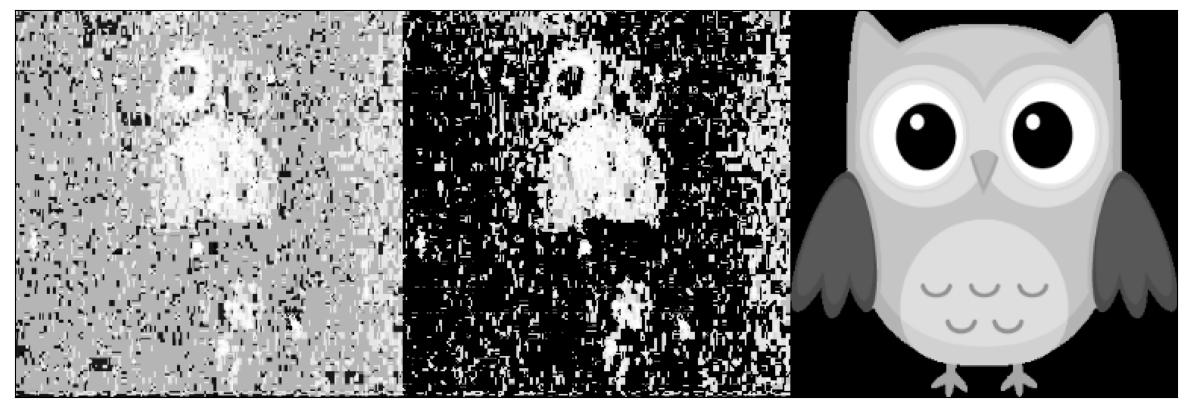

In [143]:
req = urllib.request.urlopen('https://github.com/AthimetA/FRA321/blob/main/IMGpro/img/owl.jpg?raw=true')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
imgowl = cv2.imdecode(arr, -1)
imgowl = cv2.resize(imgowl, (256, 256), interpolation=cv2.INTER_LINEAR) 
imgowl = cv2.cvtColor(imgowl, cv2.COLOR_BGR2GRAY)
vis = np.concatenate((resr, imgowl), axis=1)
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()